In [1]:
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pylab as plt
import matplotlib

In [2]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
reshape_dims = [IMG_HEIGHT,IMG_WIDTH]

CLASS_NAMES = ['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']

def read_and_decode(filename, reshape_dims):
  # 1.Read the file
  img = tf.io.read_file(filename)

  # 2.Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)

  # 3.Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)

  # 4.Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  #to find the only True label
  return img, label


In [3]:
train_dataset = (tf.data.TextLineDataset('/Users/zhuzhirui/.keras/datasets/flower_photos/train_set.csv')
                 .map(decode_csv)).batch(10)

eval_dataset = (tf.data.TextLineDataset("/Users/zhuzhirui/.keras/datasets/flower_photos/eval_set.csv")
                .map(decode_csv)).batch(10)
#The size of each batch is 10 samples

#A Linear Model
model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


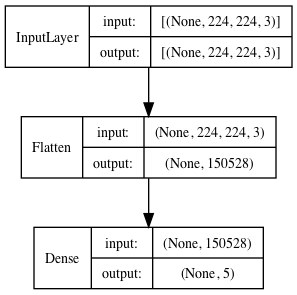

In [4]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [5]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
331/331 [==============================] - 3s 8ms/step - loss: 16.0652 - accuracy: 0.3505 - val_loss: 18.8764 - val_accuracy: 0.3577
Epoch 2/10
331/331 [==============================] - 3s 8ms/step - loss: 15.4202 - accuracy: 0.4126 - val_loss: 16.7552 - val_accuracy: 0.3089
Epoch 3/10
331/331 [==============================] - 3s 8ms/step - loss: 14.3843 - accuracy: 0.4526 - val_loss: 20.7652 - val_accuracy: 0.3252
Epoch 4/10
331/331 [==============================] - 3s 9ms/step - loss: 13.5773 - accuracy: 0.4911 - val_loss: 27.2745 - val_accuracy: 0.2873
Epoch 5/10
331/331 [==============================] - 3s 9ms/step - loss: 13.1002 - accuracy: 0.5041 - val_loss: 30.8098 - val_accuracy: 0.2710
Epoch 6/10
331/331 [==============================] - 3s 8ms/step - loss: 14.0627 - accuracy: 0.5020 - val_loss: 26.5852 - val_accuracy: 0.3686
Epoch 7/10
331/331 [==============================] - 3s 9ms/step - loss: 11.0247 - accuracy: 0.5616 - val_loss: 27.5906 - val_accuracy:

In [6]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


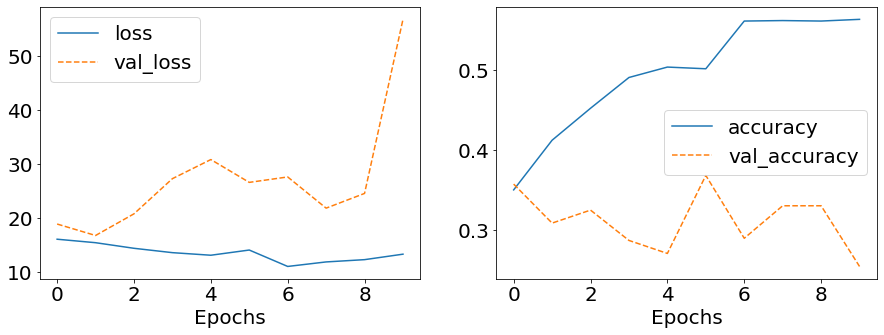

In [7]:
matplotlib.rcParams.update({'font.size': 20})
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

training_plot(['loss', 'accuracy'], history);

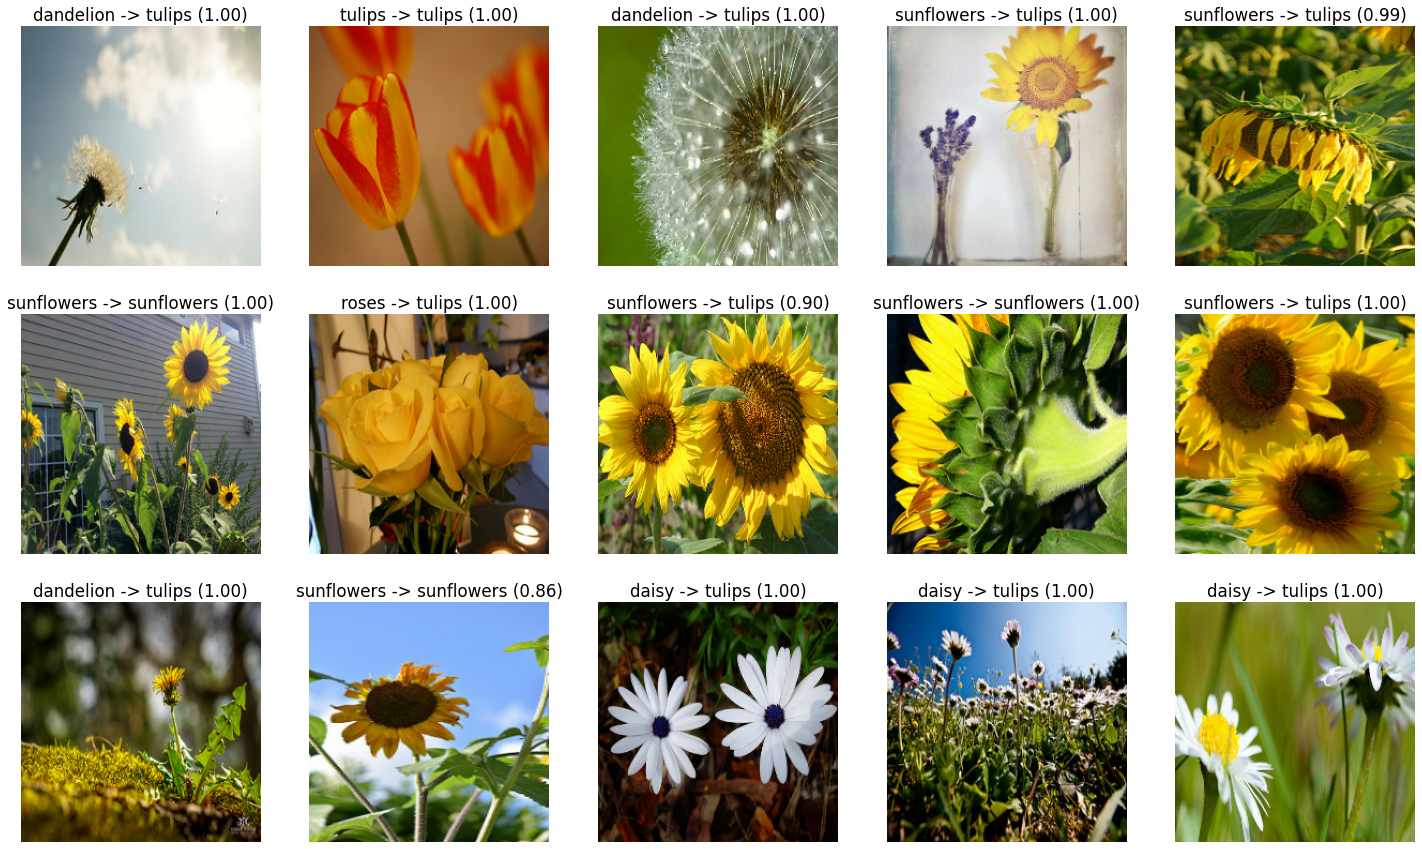

In [8]:
#Plot its predictions on a few images from the training dataset
def plot_predictions(filename):
  matplotlib.rcParams.update({'font.size': 14})
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).map(decode_csv))

  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

plot_predictions("/Users/zhuzhirui/.keras/datasets/flower_photos/train_set.csv")

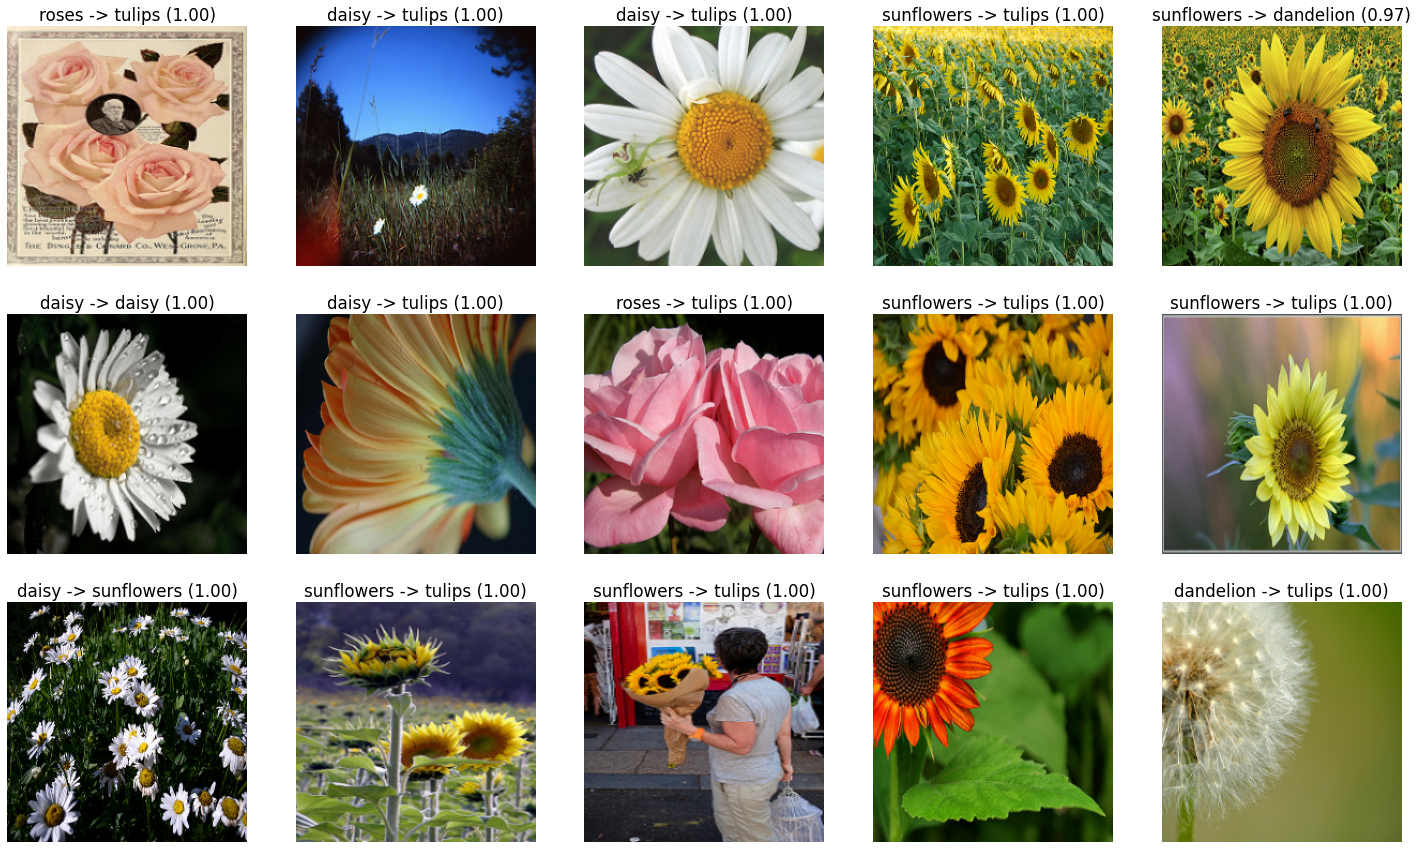

In [9]:
plot_predictions("/Users/zhuzhirui/.keras/datasets/flower_photos/eval_set.csv")

Scaling weights for roses in -0.09674017876386642 to 0.12786860764026642
[0.5427431  0.5207238  0.5476225  ... 0.53214556 0.52268434 0.5479785 ]
Scaling weights for sunflowers in -0.15523721277713776 to 0.1310419738292694
[0.5369646  0.5468553  0.7014851  ... 0.5486174  0.568028   0.31806043]
Scaling weights for daisy in -0.11713561415672302 to 0.12803682684898376
[0.5328163  0.5174991  0.40012044 ... 0.47454688 0.48847586 0.6290136 ]
Scaling weights for dandelion in -0.12429983168840408 to 0.13894064724445343
[0.44887933 0.48475668 0.41349062 ... 0.36187875 0.45726335 0.41713473]
Scaling weights for tulips in -0.1186274066567421 to 0.16247090697288513
[0.30028793 0.2752086  0.3076511  ... 0.51402843 0.3618594  0.46916437]


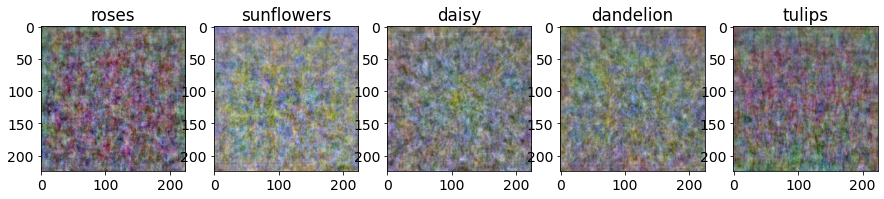

In [14]:
def show_trained_weights(model):
  # CLASS_NAMES = ['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    #has 150528(224*224*3) weights and 1 bias
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    #make weights range in (0,1)
    print(weights)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

show_trained_weights(model)